# Compares LGAR (C and Python) three synthetic examples against Hydrus (benchmark solution)
### Date : April 11, 2023 (last updated)

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
import importlib as imp
import copy
import pandas as pd
import datetime as dt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

import pickle

#### Make sure to update/provide the correct local paths. 
#### Works for synthetic examples 1, 2, and 3 as we have the corresponding python and hydrus output data

In [6]:
# Python version
sim_case = 'output_synth_2.pkl' 
#py_path_vars = '/Users/ahmadjan/codes/side/lgar-py-dec15/LGAR-Py/outputs/%s'%sim_case
py_path_vars = '/Users/peterlafollette/Desktop/ngen_test_2/ngen/extern/LGAR-C/tests/Python_outputs/synth_2/output_synth_2.pkl'

# C version
sim_case = './outputs/synthetic2/data_variables.csv'
#c_path_vars = '/Users/ahmadjan/codes/codes_test/LGAR-C/%s'%sim_case
c_path_vars = sim_case

#outfile = "/Users/ahmadjan/codes/codes_test/LGAR-C/outputs/synthetic1/c-py-hydrus-comparison_synthetic1.png"
outfile = "/Users/peterlafollette/Desktop/ngen_test_2/ngen/extern/LGAR-C/tests/c-py-hydrus-comparison_synthetic2.png"

save_outfile = True

In [7]:
num_steps = 144
    
start = pd.Timestamp("2016-10-01 00:00:00")
end=pd.Timestamp("2016-10-01 11:55:00")
times = pd.date_range(start=start,end=end, periods=num_steps) #freq='min'
times_bmi = pd.date_range(start=start,end=end, periods=num_steps)

xfmt = mdates.DateFormatter('%Y/%m/%d')


In [8]:
data_py_vars = pd.read_pickle(py_path_vars)
data_py_vars.head()


,P(mm/h),PET(mm/h),runoff[mm/h],actual_infil[mm/h],ponded_head[mm],bottom_flux[mm/h],water_in_soil[mm],mass_bal_error(mm),actual_ET_per_step(mm)
Datetime_date,,,,,,,,,
2016-10-01 00:00:00,0.0,0.0,0.0,0.0,0,0.0,178.65011,0.0,0.0
2016-10-01 00:05:00,0.0,0.0,0.0,0.0,0,0.0,178.65011,0.0,0.0
2016-10-01 00:10:00,0.0,0.0,0.0,0.0,0,0.0,178.65011,0.0,0.0
2016-10-01 00:15:00,0.0,0.0,0.0,0.0,0,0.0,178.65011,0.0,0.0
2016-10-01 00:20:00,0.0,0.0,0.0,0.0,0,0.0,178.65011,0.0,0.0


In [9]:
data_c_vars = pd.read_csv(c_path_vars)
data_c_vars.head()

,Time,precipitation,potential_evapotranspiration,actual_evapotranspiration,surface_runoff,giuh_runoff,soil_storage,total_discharge,infiltration,percolation,mass_balance
0,2016-10-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.17865,0.0,0.0,0.0,0.0
1,2016-10-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.17865,0.0,0.0,0.0,0.0
2,2016-10-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.17865,0.0,0.0,0.0,0.0
3,2016-10-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.17865,0.0,0.0,0.0,0.0
4,2016-10-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.17865,0.0,0.0,0.0,0.0


In [10]:
m_to_mm = 1000


### Read Hydrus data

In [11]:
## Note: Hydrus output data is stored in LGAR-py repo, and the below path needs to be updated
#hyd_path = '/Users/ahmadjan/codes/side/lgar-py-dec15/LGAR-Py/HYDRUS_files/synthetic_test_1_HYDRUS/T_Level.txt'
hyd_path = '/Users/peterlafollette/Desktop/ngen_test_2/ngen/extern/LGAR-C/tests/HYDRUS_outputs/synth_2/T_Level.txt'

HYDRUS_output = pd.read_fwf(hyd_path,widths=[13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13])            
HYDRUS_datetime_vec = []
for i in range(0,len(HYDRUS_output['Time'])):
    current_dt = data_py_vars.index[0] + dt.timedelta(minutes=HYDRUS_output['Time'][i])
    HYDRUS_datetime_vec.append(current_dt)
HYDRUS_output['HYDRUS_datetime_vec'] = HYDRUS_datetime_vec
HYDRUS_output = HYDRUS_output.set_index('HYDRUS_datetime_vec')

HYDRUS_output.head()

,Time,rTop,rRoot,vTop,vRoot,vBot,sum(rTop,) sum(rRoot,) sum(vTop,) sum(vRoot,...,hRoot,hBot,RunOff,sum(RunOff,) Volume,sum(Infil,) sum(Evap,) TLevel Cum(,WTrans) Snow,Layer
HYDRUS_datetime_vec,,,,,,,,,,,,,,,,,,,,,
2016-10-01 00:05:00,5.0,0.0,0.0,3.170700e-10,0.0,1.164200e-09,0.0,0.0,1.585400e-09,0.0,...,0.0,-994.13,0.0,0.0,179.42,0.0,1.585400e-09,1 0.00,0.0,0.0
2016-10-01 00:10:00,10.0,0.0,0.0,2.521600e-10,0.0,1.135000e-09,0.0,0.0,2.846100e-09,0.0,...,0.0,-991.55,0.0,0.0,179.42,0.0,2.846100e-09,2 0.00,0.0,0.0
2016-10-01 00:15:00,15.0,0.0,0.0,3.854000e-11,0.0,2.273700e-09,0.0,0.0,3.038800e-09,0.0,...,0.0,-989.12,0.0,0.0,179.42,0.0,3.038800e-09,3 0.00,0.0,0.0
2016-10-01 00:20:00,20.0,0.0,0.0,-5.813900e-10,0.0,-6.602900e-09,0.0,0.0,1.318800e-10,0.0,...,0.0,-987.31,0.0,0.0,179.42,0.0,3.038800e-09,4 0.00,0.0,0.0
2016-10-01 00:25:00,25.0,0.0,0.0,-1.067500e-09,0.0,4.623900e-09,0.0,0.0,-5.205700e-09,0.0,...,0.0,-985.67,0.0,0.0,179.42,0.0,3.038800e-09,5 0.00,0.0,0.0


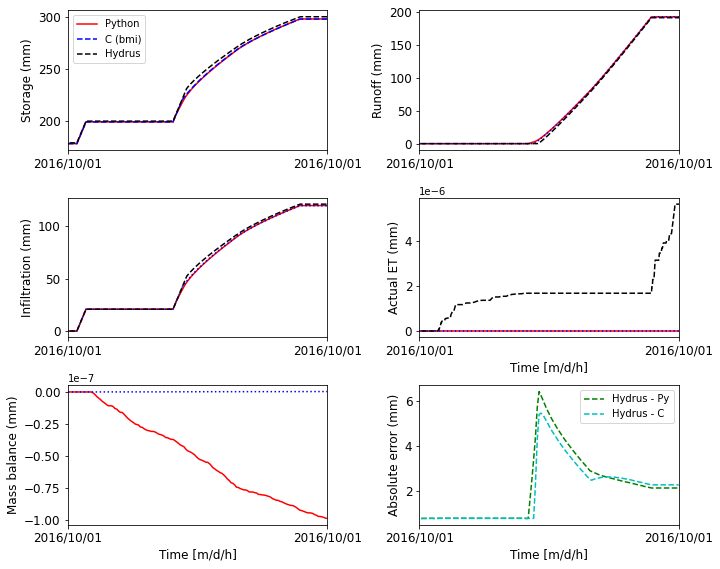

In [12]:

#%matplotlib qt
fig, axs = plt.subplots(3,2, figsize=(10,8), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

vars_py = ['water_in_soil[mm]', 'runoff[mm/h]', 'actual_infil[mm/h]', 'actual_ET_per_step(mm)', 'mass_bal_error(mm)']
vars_bmi = ['soil_storage', 'surface_runoff', 'infiltration', 'actual_evapotranspiration', 'mass_balance']
vars_hydrus = [')     Volume', 'sum(RunOff', 'sum(Infil', ')    sum(Evap']
m_to_mm= 1000
timestep = 300/3600
y_labels = ['Storage (mm)', 'Runoff (mm)', 'Infiltration (mm)', 'Actual ET (mm)', 'Mass balance (mm)', 'Absolute error (mm)']

for i in range(len(y_labels)):
    if i == 0 or i == 5:
        if i == 0:
            axs[i].plot(data_py_vars[vars_py[i]],'r',label='Python')
            axs[i].plot(times_bmi, data_c_vars[vars_bmi[i]]*m_to_mm,'b',linestyle='dashed',label='C (bmi)')
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus')
        else:
            ## plotting absolute difference between Hydrus vs LGAR-C and LGAR-Py
            hyd = []
            for t,v1 in zip(HYDRUS_output['Time'], HYDRUS_output[vars_hydrus[0]]):
                if t % 5.0 == 0:
                    hyd.append(v1)
            hyd_c_diff = []

            #hydrus output data does not include t=0 data
            for v2, v3 in zip(np.array(hyd),np.array(data_c_vars[vars_bmi[0]]*m_to_mm)[1:]):
                hyd_c_diff.append(abs(v2-v3))

            hyd_py_diff = []
            for v2, v3 in zip(np.array(hyd),np.array(data_py_vars[vars_py[0]])[1:]):
                hyd_py_diff.append(abs(v2-v3))
            axs[i].plot(times_bmi[1:], hyd_py_diff,'g',linestyle='dashed',label='Hydrus - Py')
            axs[i].plot(times_bmi[1:], hyd_c_diff,'c',linestyle='dashed',label='Hydrus - C')
            axs[i].legend()
        
    elif (i < len(vars_hydrus)):
        if i == 1 or i == 2 or i ==3: 
            axs[i].plot(np.cumsum(data_py_vars[vars_py[i]])*timestep,'r',label='Python')
            
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_mm),'b',linestyle='dotted',label='C (bmi)')
        axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus')
        
    else:
        axs[i].plot(np.cumsum(data_py_vars[vars_py[i]]),'r',label='Python')
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_mm),'b',linestyle='dotted',label='C (bmi)')

            
    axs[i].set_ylabel(y_labels[i],fontsize=12)
    
    if i >2:
        axs[i].set_xlabel('Time [m/d/h]',fontsize=12)
    axs[i].tick_params(axis='x', labelsize=12,rotation=0)
    axs[i].tick_params(axis='y', labelsize=12,rotation=0)
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    
    axs[i].set_xlim(times_bmi[0], times_bmi[-1])
#axs[5].axis('OFF')
axs[0].legend()
plt.tight_layout()

if (save_outfile):
    plt.savefig(outfile,dpi=200)
